In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [6]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [7]:
# hyperparameters
N = 5
k = 2
tau = 1.

In [8]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [10]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [11]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [12]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        
    def forward(self, x):
        return F.sigmoid(self.fc1(x))

In [13]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

# def signal(outputs):
#     outputs = [sample(out).narrow(1,0,1) for out in outputs]
#     return torch.cat(outputs, dim=1)
    

In [14]:
class Decoder(nn.Module):  
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(N, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)      
        self.fc4 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        o = h4.view(-1,784)
        return F.sigmoid(o)

In [15]:
E = Encoder()
D = Decoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]
T1s = [Tunnel() for _ in range(N-1)]
Gs = [Gate() for _ in range(N-1)]

In [16]:
from itertools import product
    
log_two_pow_n = Variable(torch.Tensor([2**N]).log(), requires_grad=False)
# TODO cuda it

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    acc_i = 0
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        sofar = E(x)
        outputs = [O0(sofar)]

        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](path[n]) # Kind of doing "teacher forcing"
            outputs.append(Os[n](sofar))

        q = prob(outputs)

        # TODO is there a better way to select along a dim?
        _idx = path.data
        _idx = torch.cat([(1-_idx).unsqueeze(1), _idx.unsqueeze(1)], 1)
        _idx = Variable(_idx, requires_grad=False)
        _idx = _idx.expand(x.shape[0], _idx.shape[0], _idx.shape[1])
        _idx = _idx.byte()

        # Debug
    #     print(q)
    #     print(path)
    #     print(q.masked_select(_idx))

        probs = q.masked_select(_idx)

    #     # less numerically stable
    #     q = probs.log().sum().exp()
    #     kl_term = q.mul(q.log() + log_two_pow_n) # TODO get rid of numpy

        # more numerically stable
        log_q = (probs+1e-20).log().sum() # TODO hacky to fix log becoming inf
        kl_term = log_q.exp().mul(log_two_pow_n + log_q)

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [17]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    x = data.view(-1,784)
    x = x[0:1]
    break
    
get_dependent_prior_loss(x)

Variable containing:
1.00000e-04 *
  9.1317
[torch.FloatTensor of size 1]

In [18]:
# TODO
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
    # Assuming independent latent
#     KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    # Assuming dependent latent
    KLD = get_dependent_prior_loss(x)
    
    return BCE + KLD

In [19]:
# training
epochs = 10

params = [
    {'params':E.parameters()},
    {'params':D.parameters()},
    {'params':O0.parameters()},
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts] + [{'params': g.parameters()} for g in Gs]
optimizer = optim.Adam(params, lr=1e-4)

train_loss = 0
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        x = data.view(-1,784)
        optimizer.zero_grad()
        sofar = E(x)
        outputs = [O0(sofar)]
        samples = [sample(outputs[-1])]
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](samples[-1])
            outputs.append(Os[n](sofar))
            samples.append(sample(outputs[-1]))
#         for n in range(len(T1s)):
#             soforth = T1s[n](outputs[n])

#         recon_x = D(soforth)
            
        bits = torch.cat(samples, dim=1)
        q = prob(outputs)
        recon_x = D(bits)
        loss = loss_function(recon_x, x, q)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch+1, train_loss / len(train_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 542.743320
Train Epoch: 1 [20000/60000 (33%)]	Loss: 206.597891
Train Epoch: 1 [40000/60000 (67%)]	Loss: 201.881309
====> Epoch: 1 Average loss: 234.3373
Train Epoch: 2 [0/60000 (0%)]	Loss: 189.357246
Train Epoch: 2 [20000/60000 (33%)]	Loss: 201.327383
Train Epoch: 2 [40000/60000 (67%)]	Loss: 192.332754
====> Epoch: 2 Average loss: 428.5909
Train Epoch: 3 [0/60000 (0%)]	Loss: 194.700234
Train Epoch: 3 [20000/60000 (33%)]	Loss: 190.167539
Train Epoch: 3 [40000/60000 (67%)]	Loss: 190.780391
====> Epoch: 3 Average loss: 620.4394
Train Epoch: 4 [0/60000 (0%)]	Loss: 190.616484
Train Epoch: 4 [20000/60000 (33%)]	Loss: 181.327188
Train Epoch: 4 [40000/60000 (67%)]	Loss: 178.462871
====> Epoch: 4 Average loss: 806.4095
Train Epoch: 5 [0/60000 (0%)]	Loss: 186.105566
Train Epoch: 5 [20000/60000 (33%)]	Loss: 175.810547
Train Epoch: 5 [40000/60000 (67%)]	Loss: 170.164199
====> Epoch: 5 Average loss: 985.7366
Train Epoch: 6 [0/60000 (0%)]	Loss: 173.207617
Train Ep

In [20]:
q

Variable containing:
( 0 ,.,.) = 
  1.0000e+00  7.3847e-07
  9.9950e-01  5.0239e-04
  3.9478e-01  6.0522e-01
  4.2249e-03  9.9578e-01
  4.4656e-05  9.9996e-01

( 1 ,.,.) = 
  6.4015e-05  9.9994e-01
  8.6019e-05  9.9991e-01
  1.5498e-03  9.9845e-01
  9.9996e-01  3.8534e-05
  1.6997e-11  1.0000e+00

( 2 ,.,.) = 
  1.2252e-05  9.9999e-01
  8.1277e-01  1.8723e-01
  6.8557e-01  3.1443e-01
  1.0000e+00  2.6835e-06
  7.6302e-17  1.0000e+00
... 

(97 ,.,.) = 
  1.6409e-01  8.3591e-01
  9.9955e-01  4.5477e-04
  4.6864e-01  5.3136e-01
  8.5946e-01  1.4054e-01
  2.6085e-16  1.0000e+00

(98 ,.,.) = 
  9.2785e-08  1.0000e+00
  7.6906e-03  9.9231e-01
  9.9837e-01  1.6273e-03
  9.0698e-01  9.3019e-02
  5.5783e-13  1.0000e+00

(99 ,.,.) = 
  2.0036e-03  9.9800e-01
  1.3056e-04  9.9987e-01
  3.4141e-04  9.9966e-01
  9.9995e-01  5.0259e-05
  3.0345e-06  1.0000e+00
[torch.FloatTensor of size 100x5x2]

In [21]:
bits

Variable containing:
    1     1     1     0     0
    0     0     0     1     0
    0     1     1     1     0
    0     0     1     0     0
    1     0     1     1     0
    1     1     0     0     0
    0     1     1     1     0
    1     1     0     1     0
    1     1     0     1     0
    1     1     1     1     0
    1     0     0     1     0
    0     0     0     1     0
    0     1     1     0     0
    0     0     0     1     0
    1     1     1     0     0
    1     1     0     0     0
    1     0     0     1     0
    0     0     0     1     0
    1     1     1     1     0
    1     0     1     0     0
    1     0     0     1     0
    1     1     0     0     0
    1     0     1     0     0
    0     1     0     1     0
    0     0     0     0     0
    1     0     0     1     0
    1     0     0     0     0
    0     0     0     1     0
    1     0     0     1     0
    0     1     1     0     0
    0     0     0     1     0
    0     1     0     1     0
    0     1     1  

In [22]:
test_set = dset.MNIST('data', train=False, download=True, transform=data_transforms)

In [23]:
# a = np.array([[0., 0., 0., 0.]])
# w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
# plt.imshow(w.view(28,28).data.numpy())

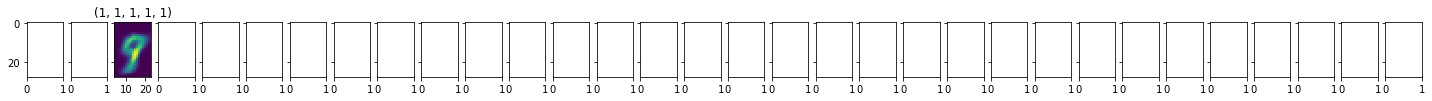

In [25]:
from itertools import product
f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
kk = 0
for path in product(range(2), repeat=N):
    w = D.forward(Variable(torch.Tensor(path).type(torch.FloatTensor)))
    ax = axes[k]
    ax.set_title(path)
    ax.imshow(w.view(28,28).data.numpy())
    kk += 1